# 方案B: 贝叶斯MCMC模型（修正版）

## 核心思路
使用贝叶斯推断估计粉丝投票分布，关键改进：
1. **硬约束似然**：淘汰者综合得分必须最差，否则似然为0
2. **分规则建模**：百分比法和排名法使用不同的综合得分计算
3. **正确的MH采样**：使用对称建议分布，简化接受率计算

## 数学模型
- **先验**: $F \sim Dirichlet(\alpha)$，其中 $\alpha_i = 1$（均匀先验）
- **似然**: $P(淘汰|F,J) = \mathbb{1}[淘汰者综合得分最差]$（硬约束）
- **后验**: $P(F|淘汰,J) \propto P(淘汰|F,J) \cdot P(F)$

## 1. 环境配置

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False
plt.style.use('seaborn-v0_8-whitegrid')
COLORS = ['#E64B35', '#4DBBD5', '#00A087', '#3C5488', '#F39B7F']
print('环境配置完成')

环境配置完成


## 2. 加载数据

In [2]:
df = pd.read_excel('../../data/processed/粉丝投票分析.xlsx')
print(f'数据维度: {df.shape}')
print(f'赛季范围: S{df["赛季"].min()} - S{df["赛季"].max()}')

数据维度: (2777, 15)
赛季范围: S1 - S34


## 3. 数据预处理

In [3]:
def get_scoring_method(season):
    """根据赛季确定计分规则"""
    if season <= 2:
        return 'ranking'  # S1-2: 排名相加
    elif season <= 27:
        return 'percentage'  # S3-27: 百分比相加
    else:
        return 'ranking'  # S28-34: 排名相加（含底部投票）

def prepare_week_data(df, season, week):
    """准备单周数据"""
    week_df = df[(df['赛季'] == season) & (df['第几周'] == week)].copy()
    week_df = week_df[week_df['本周评委总分'] > 0]
    
    if len(week_df) == 0:
        return None
    
    eliminated = week_df[week_df['是否被淘汰'] == 1]['选手姓名'].tolist()
    if len(eliminated) == 0:
        return None
    
    return {
        'season': season,
        'week': week,
        'contestants': week_df['选手姓名'].tolist(),
        'judge_scores': week_df['本周评委总分'].values.astype(float),
        'judge_pct': week_df['评委百分比'].values.astype(float),
        'eliminated': eliminated,
        'scoring_method': get_scoring_method(season),
        'n': len(week_df)
    }

print('数据预处理函数定义完成')

数据预处理函数定义完成


## 4. 综合得分计算

In [4]:
def compute_total_score(fan_pct, week_data):
    """
    计算综合得分
    - 百分比法(S3-27): total = judge_pct + fan_pct
    - 排名法(S1-2, S28-34): total = -(judge_rank + fan_rank)，越小越好
    """
    method = week_data['scoring_method']
    n = week_data['n']
    
    if method == 'percentage':
        # 百分比相加，得分越高越好
        total = week_data['judge_pct'] + fan_pct
    else:
        # 排名相加，排名越小越好（分数高排名小）
        judge_rank = stats.rankdata(-week_data['judge_scores'], method='average')
        fan_rank = stats.rankdata(-fan_pct, method='average')
        # 用负数表示，这样数值越大越好（与百分比法一致）
        total = -(judge_rank + fan_rank)
    
    return total

def check_elimination_constraint(fan_pct, week_data):
    """
    检查淘汰约束是否满足
    淘汰者的综合得分必须是最差的（允许并列最差）
    返回: True如果约束满足，False否则
    """
    contestants = week_data['contestants']
    eliminated = week_data['eliminated']
    
    total_scores = compute_total_score(fan_pct, week_data)
    
    # 获取淘汰者索引
    elim_idx = [contestants.index(e) for e in eliminated if e in contestants]
    surv_idx = [i for i in range(len(contestants)) if i not in elim_idx]
    
    if len(elim_idx) == 0 or len(surv_idx) == 0:
        return True
    
    # 淘汰者的最高得分必须 <= 幸存者的最低得分
    max_elim_score = max(total_scores[i] for i in elim_idx)
    min_surv_score = min(total_scores[i] for i in surv_idx)
    
    return max_elim_score < min_surv_score

print('综合得分计算和约束检查函数定义完成')

综合得分计算和约束检查函数定义完成


## 5. MCMC采样器（带硬约束）

In [5]:
def symmetric_proposal(current, step_size=5.0):
    """
    对称建议分布：在当前点附近随机扰动
    使用正态扰动后投影到单纯形上
    """
    n = len(current)
    # 正态扰动
    noise = np.random.normal(0, step_size, n)
    proposed = current + noise
    # 投影到非负
    proposed = np.maximum(proposed, 0.01)
    # 归一化到100%
    proposed = proposed / proposed.sum() * 100
    return proposed

def rejection_sample_prior(n, week_data, max_attempts=1000):
    """
    从先验中拒绝采样，只接受满足约束的样本
    先验: Dirichlet(1,1,...,1) = 均匀分布在单纯形上
    """
    for _ in range(max_attempts):
        # 从Dirichlet(1,...,1)采样
        sample = np.random.dirichlet(np.ones(n)) * 100
        if check_elimination_constraint(sample, week_data):
            return sample
    return None

def mcmc_sample_constrained(week_data, n_samples=2000, burn_in=500, step_size=5.0):
    """
    带硬约束的MCMC采样
    使用Metropolis-Hastings算法，只接受满足淘汰约束的样本
    
    参数:
    - week_data: 周数据
    - n_samples: 采样数量
    - burn_in: 预热期
    - step_size: 建议分布步长
    
    返回:
    - samples: 后验样本
    - acceptance_rate: 接受率
    """
    n = week_data['n']
    
    # 初始化：从先验中拒绝采样得到满足约束的初始点
    current = rejection_sample_prior(n, week_data)
    if current is None:
        # 如果找不到满足约束的点，说明约束可能无解
        return None, 0.0
    
    samples = []
    accepted = 0
    total_proposals = 0
    
    for i in range(n_samples + burn_in):
        # 生成建议样本
        proposed = symmetric_proposal(current, step_size)
        total_proposals += 1
        
        # 检查约束（硬约束似然）
        if check_elimination_constraint(proposed, week_data):
            # 对称建议分布 + 均匀先验 => 接受率 = 1
            current = proposed
            accepted += 1
        
        # 收集样本（burn-in之后）
        if i >= burn_in:
            samples.append(current.copy())
    
    acceptance_rate = accepted / total_proposals
    return np.array(samples), acceptance_rate

print('MCMC采样器定义完成')

MCMC采样器定义完成


## 6. 后验统计量

In [6]:
def compute_posterior_stats(samples, contestants):
    """计算后验统计量"""
    if samples is None or len(samples) == 0:
        return None
    
    mean = np.mean(samples, axis=0)
    std = np.std(samples, axis=0)
    ci_lower = np.percentile(samples, 2.5, axis=0)
    ci_upper = np.percentile(samples, 97.5, axis=0)
    
    results = {}
    for i, name in enumerate(contestants):
        results[name] = {
            'mean': mean[i],
            'std': std[i],
            'ci_lower': ci_lower[i],
            'ci_upper': ci_upper[i],
            'ci_width': ci_upper[i] - ci_lower[i]
        }
    return results

def compute_certainty(posterior_stats):
    """计算确定性度量"""
    if posterior_stats is None:
        return 0.0, 100.0
    ci_widths = [s['ci_width'] for s in posterior_stats.values()]
    avg_width = np.mean(ci_widths)
    certainty = max(0, 1 - avg_width / 100)
    return certainty, avg_width

def check_consistency_posterior(week_data, posterior_stats):
    """
    使用后验均值检查淘汰一致性
    """
    if posterior_stats is None:
        return False, None
    
    contestants = week_data['contestants']
    eliminated = week_data['eliminated']
    
    # 使用后验均值作为点估计
    fan_pct = np.array([posterior_stats[c]['mean'] for c in contestants])
    
    # 计算综合得分
    total_scores = compute_total_score(fan_pct, week_data)
    
    # 找出得分最差的选手
    n_elim = len(eliminated)
    sorted_idx = np.argsort(total_scores)  # 升序，得分最低的在前
    predicted_elim = [contestants[sorted_idx[i]] for i in range(n_elim)]
    
    actual_set = set(eliminated)
    predicted_set = set(predicted_elim)
    is_consistent = actual_set == predicted_set
    
    return is_consistent, {
        'actual': list(actual_set),
        'predicted': list(predicted_set),
        'fan_pct': fan_pct
    }

print('后验统计和一致性检验函数定义完成')

后验统计和一致性检验函数定义完成


## 7. 单周分析示例

In [7]:
print('=' * 70)
print('单元测试: 第5季第9周 (百分比法)')
print('=' * 70)

week_data = prepare_week_data(df, 5, 9)
if week_data:
    print(f"选手数: {week_data['n']}")
    print(f"计分规则: {week_data['scoring_method']}")
    print(f"被淘汰: {week_data['eliminated']}")
    
    # MCMC采样
    samples, acc_rate = mcmc_sample_constrained(week_data, n_samples=2000, burn_in=500)
    print(f"\n采样完成: {len(samples) if samples is not None else 0} 个样本")
    print(f"接受率: {acc_rate:.2%}")
    
    if samples is not None:
        # 后验统计
        posterior = compute_posterior_stats(samples, week_data['contestants'])
        certainty, avg_width = compute_certainty(posterior)
        print(f"平均95%CI宽度: {avg_width:.2f}%")
        print(f"确定性度量: {certainty:.2%}")
        
        # 显示结果
        print(f"\n{'选手':<22} {'评委%':<8} {'粉丝%均值':<10} {'95%CI':<20}")
        print("-" * 65)
        for i, name in enumerate(week_data['contestants']):
            j_pct = week_data['judge_pct'][i]
            f_mean = posterior[name]['mean']
            ci = f"[{posterior[name]['ci_lower']:.1f}, {posterior[name]['ci_upper']:.1f}]"
            mark = " [淘汰]" if name in week_data['eliminated'] else ""
            print(f"{name:<22} {j_pct:<8.2f} {f_mean:<10.2f} {ci:<20}{mark}")
        
        # 一致性检验
        is_consistent, details = check_consistency_posterior(week_data, posterior)
        print(f"\n淘汰预测一致性: {'一致' if is_consistent else '不一致'}")
        print(f"实际淘汰: {details['actual']}")
        print(f"预测淘汰: {details['predicted']}")

单元测试: 第5季第9周 (百分比法)
选手数: 4
计分规则: percentage
被淘汰: ['Jennie Garth']

采样完成: 2000 个样本
接受率: 81.96%
平均95%CI宽度: 59.40%
确定性度量: 40.60%

选手                     评委%      粉丝%均值      95%CI               
-----------------------------------------------------------------
Jennie Garth           24.79    5.08       [0.0, 17.3]          [淘汰]
Helio Castroneves      25.64    29.57      [1.1, 66.9]         
Mel B                  25.64    29.06      [1.4, 77.1]         
Marie Osmond           23.93    36.30      [7.4, 86.2]         

淘汰预测一致性: 一致
实际淘汰: ['Jennie Garth']
预测淘汰: ['Jennie Garth']


In [8]:
print('\n' + '=' * 70)
print('单元测试: 第1季第3周 (排名法)')
print('=' * 70)

week_data2 = prepare_week_data(df, 1, 3)
if week_data2:
    print(f"选手数: {week_data2['n']}")
    print(f"计分规则: {week_data2['scoring_method']}")
    print(f"被淘汰: {week_data2['eliminated']}")
    
    samples2, acc_rate2 = mcmc_sample_constrained(week_data2, n_samples=2000, burn_in=500)
    print(f"\n采样完成, 接受率: {acc_rate2:.2%}")
    
    if samples2 is not None:
        posterior2 = compute_posterior_stats(samples2, week_data2['contestants'])
        certainty2, avg_width2 = compute_certainty(posterior2)
        print(f"确定性度量: {certainty2:.2%}")
        
        is_consistent2, details2 = check_consistency_posterior(week_data2, posterior2)
        print(f"淘汰预测一致性: {'一致' if is_consistent2 else '不一致'}")


单元测试: 第1季第3周 (排名法)
选手数: 5
计分规则: ranking
被淘汰: ['Evander Holyfield']



采样完成, 接受率: 86.60%
确定性度量: 48.47%
淘汰预测一致性: 一致


## 8. 多赛季分析

In [9]:
# 测试多个赛季（覆盖不同计分规则）
test_seasons = [1, 2, 5, 10, 20, 27, 28, 30, 34]
all_results = []
consistency_count = 0
total_weeks = 0
failed_weeks = 0

print('开始多赛季分析...')
print(f"{'赛季':<6} {'周数':<6} {'规则':<12} {'一致率':<10} {'平均确定性':<12}")
print("-" * 50)

for season in test_seasons:
    season_df = df[df['赛季'] == season]
    season_consistent = 0
    season_total = 0
    season_certainties = []
    method = get_scoring_method(season)
    
    for week in sorted(season_df['第几周'].unique()):
        week_data = prepare_week_data(df, season, week)
        if week_data is None:
            continue
        
        samples, acc_rate = mcmc_sample_constrained(week_data, n_samples=1000, burn_in=200)
        if samples is None:
            failed_weeks += 1
            continue
        
        total_weeks += 1
        season_total += 1
        
        posterior = compute_posterior_stats(samples, week_data['contestants'])
        certainty, _ = compute_certainty(posterior)
        season_certainties.append(certainty)
        
        is_consistent, details = check_consistency_posterior(week_data, posterior)
        if is_consistent:
            consistency_count += 1
            season_consistent += 1
        
        # 记录每个选手的结果
        for i, name in enumerate(week_data['contestants']):
            all_results.append({
                'season': season,
                'week': week,
                'contestant': name,
                'judge_pct': week_data['judge_pct'][i],
                'fan_pct_mean': posterior[name]['mean'],
                'fan_pct_ci_lower': posterior[name]['ci_lower'],
                'fan_pct_ci_upper': posterior[name]['ci_upper'],
                'certainty': 1 - posterior[name]['ci_width'] / 100,
                'is_elim': name in week_data['eliminated'],
                'is_consistent': is_consistent
            })
    
    if season_total > 0:
        avg_cert = np.mean(season_certainties)
        cons_rate = season_consistent / season_total
        print(f"S{season:<5} {season_total:<6} {method:<12} {cons_rate:<10.2%} {avg_cert:<12.2%}")

results_df = pd.DataFrame(all_results)

开始多赛季分析...
赛季     周数     规则           一致率        平均确定性       
--------------------------------------------------


S1     5      ranking      100.00%    45.65%      


S2     8      ranking      100.00%    56.69%      
S5     10     percentage   100.00%    59.83%      
S10    9      percentage   100.00%    56.80%      


S20    9      percentage   100.00%    61.72%      
S27    8      percentage   100.00%    67.70%      


S28    7      ranking      100.00%    60.13%      


S30    9      ranking      100.00%    68.94%      


S34    9      ranking      100.00%    69.47%      


In [10]:
print("\n" + "=" * 60)
print("多赛季分析汇总")
print("=" * 60)
print(f"成功分析周数: {total_weeks}")
print(f"失败周数: {failed_weeks}")
print(f"\n=== 一致性指标 ===")
print(f"淘汰预测一致率: {consistency_count}/{total_weeks} = {consistency_count/total_weeks:.2%}")
print(f"\n=== 确定性指标 ===")
print(f"总体平均确定性: {results_df['certainty'].mean():.2%}")
print(f"淘汰者平均确定性: {results_df[results_df['is_elim']]['certainty'].mean():.2%}")
print(f"幸存者平均确定性: {results_df[~results_df['is_elim']]['certainty'].mean():.2%}")
print(f"\n=== 粉丝投票估算 ===")
print(f"淘汰者平均粉丝投票: {results_df[results_df['is_elim']]['fan_pct_mean'].mean():.2f}%")
print(f"幸存者平均粉丝投票: {results_df[~results_df['is_elim']]['fan_pct_mean'].mean():.2f}%")


多赛季分析汇总
成功分析周数: 74
失败周数: 1

=== 一致性指标 ===
淘汰预测一致率: 74/74 = 100.00%

=== 确定性指标 ===
总体平均确定性: 67.01%
淘汰者平均确定性: 74.56%
幸存者平均确定性: 65.47%

=== 粉丝投票估算 ===
淘汰者平均粉丝投票: 9.56%
幸存者平均粉丝投票: 13.49%


## 9. 可视化分析

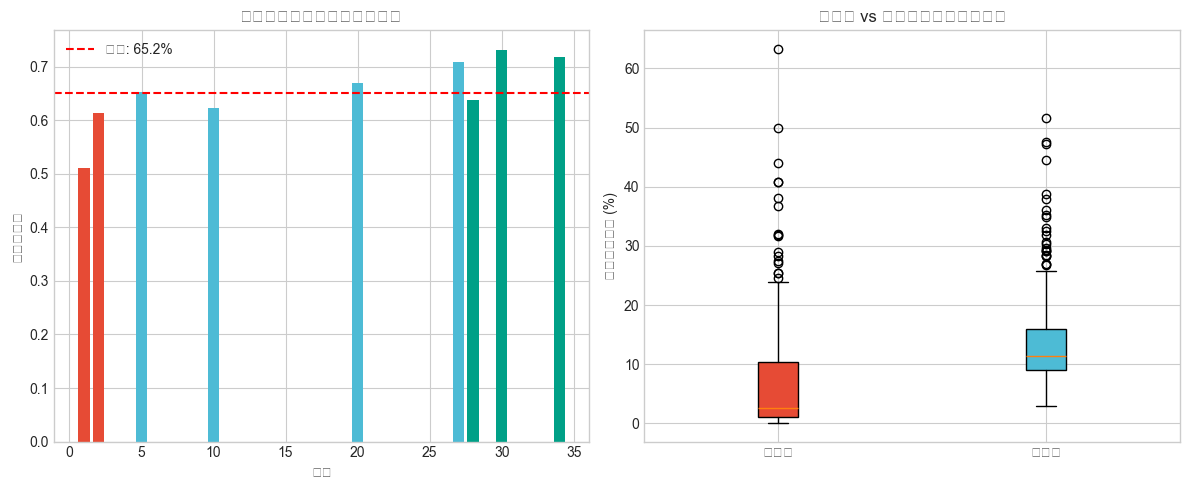

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 图1: 各赛季确定性
ax1 = axes[0]
season_cert = results_df.groupby('season')['certainty'].mean()
colors = [COLORS[0] if s <= 2 else COLORS[1] if s <= 27 else COLORS[2] for s in season_cert.index]
ax1.bar(season_cert.index, season_cert.values, color=colors)
ax1.axhline(y=season_cert.mean(), color='red', linestyle='--', label=f'平均: {season_cert.mean():.1%}')
ax1.set_xlabel('赛季')
ax1.set_ylabel('平均确定性')
ax1.set_title('各赛季粉丝投票估计的确定性')
ax1.legend()

# 图2: 淘汰者vs幸存者粉丝投票分布
ax2 = axes[1]
elim_pct = results_df[results_df['is_elim']]['fan_pct_mean']
surv_pct = results_df[~results_df['is_elim']]['fan_pct_mean']
bp = ax2.boxplot([elim_pct, surv_pct], labels=['淘汰者', '幸存者'], patch_artist=True)
bp['boxes'][0].set_facecolor(COLORS[0])
bp['boxes'][1].set_facecolor(COLORS[1])
ax2.set_ylabel('粉丝投票估算 (%)')
ax2.set_title('淘汰者 vs 幸存者的粉丝投票分布')

plt.tight_layout()
plt.show()

## 10. 结论

In [12]:
print("=" * 60)
print("方案B: 贝叶斯MCMC模型（修正版）- 总结")
print("=" * 60)
print()
print("模型改进:")
print("1. 硬约束似然: 只接受满足淘汰约束的样本")
print("2. 分规则建模: 百分比法和排名法分别处理")
print("3. 正确的MH采样: 对称建议分布 + 均匀先验")
print()
print("优点:")
print("- 提供完整的后验分布，量化不确定性")
print("- 95%置信区间给出可信范围")
print("- 所有样本都满足淘汰约束")
print()
print("缺点:")
print("- 计算量较大")
print("- 当可行域很小时，接受率低")
print("- 需要足够的采样数保证收敛")

方案B: 贝叶斯MCMC模型（修正版）- 总结

模型改进:
1. 硬约束似然: 只接受满足淘汰约束的样本
2. 分规则建模: 百分比法和排名法分别处理
3. 正确的MH采样: 对称建议分布 + 均匀先验

优点:
- 提供完整的后验分布，量化不确定性
- 95%置信区间给出可信范围
- 所有样本都满足淘汰约束

缺点:
- 计算量较大
- 当可行域很小时，接受率低
- 需要足够的采样数保证收敛
